# Exercise 6: T-type Ca²⁺-channels

In this exercise, you will explore the properties of an ion-channel type called T-type Ca²⁺ channels 
(hereby called T-channels). T-channels can generate so called Ca²⁺-spikes, which in turn may lead to bursts 
of action potentials such as that seen in Fig. 1A. You will start out with a model of a thalamic interneuron developed by Allken et al. 2014 (PLoS ONE 30;9:e107780), a neuron type which is known to elicit such T-channel mediated bursts. You can develop this model further to solve the exercise. The model contains:

* A detailed morphology (Fig. 1B).
* Three types of ion channels: Na⁺ and K⁺ channels for action-potential generation, and T-channels.
* A synapse inserted in the soma, activated at $t=$ 60 ms (you need to adjust its weight).
* A figure that plots the membrane potential at 4 different locations (soma + 3 locations along a selected dendritic branch, as denoted by the stars in Fig. 1B), as well as the synaptic input current.

<img src="Figure.png" width = "600">
__Figure 1:__ Thalamic interneuron firing a burst of action potentials. __A:__ In an experiment, a brief (10 ms), strong (0.25 nA) current injection to the soma evoked the following qualitative response features: (1) Under control conditions, the neuron responded with a burst containing a few APs (top). (2) When Na⁺-channels were blocked, the APs were eliminated (middle, black line), and the Ca²⁺-spike (bump) underlying the burst was revealed. (3) When T-channels were blocked, a passive response could be observed (grey line). __B:__ Morphology of a thalamic interneuron.

## 1) Soma response
You will now verify that the model qualitatively reproduces the "experiment" in Fig. 1A, focusing for now only on the soma-response. For simplicity, you can use the synapse as input instead of the square current injection.

__a)__ Increase the synaptic weight until you obtain a response similar to that in the top trace in Fig. 1A, i.e., the response should be a burst containing 5 action potentials.  

__b)__ Confirm that the model gives you responses similar to that in Fig. 1A (middle trace) if you block (1) only sodium channels and (2) both sodium and calcium channels. 

__c)__ Was the resting membrane potential the same in __a)__ and __b)__? Comment on the result! Note: The easiest way to explore the resting potential is probably to turn off the synapse. 


## 2) Dendritic signalling
In part 2 of the exercise, you will study how signals propagate from the soma to the distal dendrites and vice versa.

__a)__ In the simulations you ran in part 1 of the exercise, describe how different aspects of the somatically evoked response changed during its propagation through the dendrite. Compare the propagation of the action potentials with the propagation of the Ca²⁺-spike (bump), and comment on the results.

__b)__ Move the synapse from the soma to the distal dendrite. Describe how the synaptic response changes during its propagation towards the soma.

__c)__ Compare the cases in a) and b). In which direction is it easiest for a signal to travel? 


## 3) How does the distribution of T-channels affect the neural response properties?
A neuron's T-channel mediated response does not only depend on the total amount of T-channels that it possesses, but also on how these are distributed over the somatodendritic membrane. Experiments have been inconclusive regarding how T-channels are distributed in INs. One experiment indicated a uniform distribution (Parajuli et al. 2010, J Comp Neurol, 518(21):4362–4374) like the one we have considered so far in this exercise. However, another experiment indicated that the T-channel density increases with distance from soma (Munsch et al., 1997, Neuroreport, 8(11):2411–2418). In this exercise you will perform a simplified version of that project.
You will now compare these two distributions.

__a)__ Change the distribution of T-channels, so that the T-channel density increases linearly with distance ($d$) from the soma:
$$
g_{CaT}(d) = \beta \cdot (1+0.04d), \qquad (1)
$$
where $d$ is inserted with units of $\mu m$, and $\beta = 0.1054 \cdot 10^{-4}$ is a normalization constant that ensures that the distribution in Eq. (1) gives the same total number of T-channels as our previous (uniform) distribution. P.s.: In the example code, the command _h.distance()_ was used to set the soma compartment as the reference point for distance measures. In other segments, use the command _h.distance(seg.x)_ to obtain the distance between the reference point (soma) and the the relevant segment.

__b)__ Repeat the simulations in exercise 1 and 2 using the new T-channel distribution. Determine which of the two distributions (_uniform_ versus _linearly increasing with distance_) that facilitates the following response properties:
* The somatic response to somatic current injections.
* The response in distal dendrites to somatic current injections.
* The response in the soma to synaptic input in a distal dendrite.

In [2]:
%matplotlib inline
import os
from os.path import join

retval = os.getcwd()
print("Current working directory %s" % retval)
os.chdir("halnes/")
!nrnivmodl
os.chdir(retval)

import numpy as np
import pylab as plt
import scipy.stats
import neuron
from neuron import h
import LFPy

np.random.seed(1234)

In [3]:
def active_conductances(**kwarg):
    rall = 113 # axial resistance
    cap = 1.1 # membrane capacitance
    Rm = 45000.0 # membrane resistance
    Epas = -70.6
    celsius = 36

    ## INSERT ION CHANNELS:
    for sec in h.allsec():
        sec.insert("pas")
        sec.e_pas = Epas
        sec.g_pas = 1/Rm
        sec.Ra = rall
        sec.cm = cap
        sec.insert("Cad")
        sec.insert("it2")
        sec.insert("hh2")
        sec.ena = 50 # Reversal potential for sodium
        sec.ek = -90 # Reversal potential for potassium

     ##################################################################
    # Channel densities
    gna = 0.18 # S/cm2
    gkdr = 0.4
    gcat = 1.e-4

    h.celsius = celsius
    for sec in h.soma:
        h.distance()

    for sec in h.allsec():
        sec.v = Epas
        sec.e_pas = Epas
        sec.insert("pas")
        sec.e_pas = Epas
        sec.g_pas = 1/Rm
        sec.Ra = rall
        sec.cm = cap
        sec.gnabar_hh2 = 0
        sec.gkbar_hh2 = 0
        for seg in sec:
            seg.gcabar_it2 = gcat

    for sec in h.soma:
        sec.gnabar_hh2 = gna
        sec.gkbar_hh2 = gkdr
        seg.gcabar_it2 = gcat


def return_interneuron(end_T, dt, start_T, v_init=-75.):

    neuron.load_mechanisms(join("halnes"))

    cell = LFPy.Cell(morphology=join("halnes", "Morf_default.hoc"),
                     dt=dt,
                     tstart=start_T,
                     tstop=end_T,
                     nsegs_method='lambda_f',
                     lambda_f=100,
                     custom_fun=[active_conductances],
                     custom_fun_args=[{}],
                     )
    cell.simulate(rec_imem=True, rec_vmem=True)
    return cell

In [10]:
def insert_synapses(cell, weight, pos):
    '''Insert synapses'''
    
    synapse_params = {
        'e' : 0,                   #reversal potential
        'syntype' : 'Exp2Syn',      #synapse type
        'tau1' : 1,                 #syn time constant
        'tau2' : 3,                 #syn time constant
        'weight' : weight,           #syn weight
        'record_current' : True    #syn current gets recorded
    }
    
    idx = np.array([pos])
    args = dict(n=1, tstart=cell.tstart, tstop=cell.tstop,
                  distribution=scipy.stats.gamma,
                  rvs_args=dict(a=0.5, loc=0., scale=40)
                  )
    #Insert synapses in an iterative fashion
    for i in idx:
        synapse_params['idx'] = int(i)
        spiketimes = np.array([60.0])
        # Create synapse(s) and setting times using the Synapse class in LFPy
        s = LFPy.Synapse(cell, **synapse_params)
        s.set_spike_times(spiketimes)
    return s

In [14]:
def plot_signal(cell, synapse, synpos):
    """
    Plots the somatic membrane potential and somatic transmembrane currents (left), 
    as well as the cell morphology (center), and the extracellular potential (right).
    
    Parameters:
    ===========
    cell : LFPy.Cell object that contains the cell model. This function assumes that the cell simulation is finished
    electrode: Electrode object from the LFPy class RecExtElectrode 
    """
    plt.close("all")
    cell_plot_idx = 0
    fig = plt.figure(figsize=[12, 9])
    fig.subplots_adjust(hspace=0.5)  # Adjusts the vertical distance between panels.
    ax_cell = fig.add_subplot(122, aspect='equal')
    ax_cell.axis('off')
    ipos = np.array([0, 65, 110, 128]) # Found by trial and error   
    
    [ax_cell.plot([cell.xstart[idx], cell.xend[idx]], 
              [cell.ystart[idx], cell.yend[idx]], c='k') for idx in range(cell.totnsegs)]
    ax_cell.plot(cell.xmid[ipos[0]], cell.ymid[ipos[0]], '*', c='k', ms=14)
    ax_cell.plot(cell.xmid[ipos[1]], cell.ymid[ipos[1]], '*', c='b', ms=14)
    ax_cell.plot(cell.xmid[ipos[2]], cell.ymid[ipos[2]], '*', c='g', ms=14)
    ax_cell.plot(cell.xmid[ipos[3]], cell.ymid[ipos[3]], '*', c='r', ms=14)
    if synpos == ipos[0]:
        syncol = 'k'
    elif synpos == ipos[1]:
        syncol = 'b'
    elif synpos == ipos[2]:
        syncol = 'g'
    elif synpos == ipos[3]:
        syncol = 'r'
    else:
        syncol = 'm'

    el, = ax_cell.plot(cell.xmid[synpos], cell.ymid[synpos], 'd', c=syncol, ms = 16)    
    ax_cell.legend([el], ["Synapse"], frameon=False, loc="lower center")

    ax_v = fig.add_subplot(521, ylabel='mV')
    ax_v.plot(cell.tvec, cell.somav, color='k', lw=2)
    ax_v = fig.add_subplot(523, ylabel='mV')
    ax_v.plot(cell.tvec, cell.vmem[ipos[1]], color='b', lw=2)
    ax_v = fig.add_subplot(525, ylabel='mV')
    ax_v.plot(cell.tvec, cell.vmem[ipos[2]], color='g', lw=2)
    ax_v = fig.add_subplot(527, xlabel='Time [ms]', ylabel='mV')
    ax_v.plot(cell.tvec, cell.vmem[ipos[3]], color='r', lw=2)
    ax_v = fig.add_subplot(529, xlabel='Time [ms]', ylabel='nA')    
    ax_v.plot(cell.tvec, synapse.i, color= syncol, lw=2)

Mechanisms already loaded from path: halnes.  Aborting.


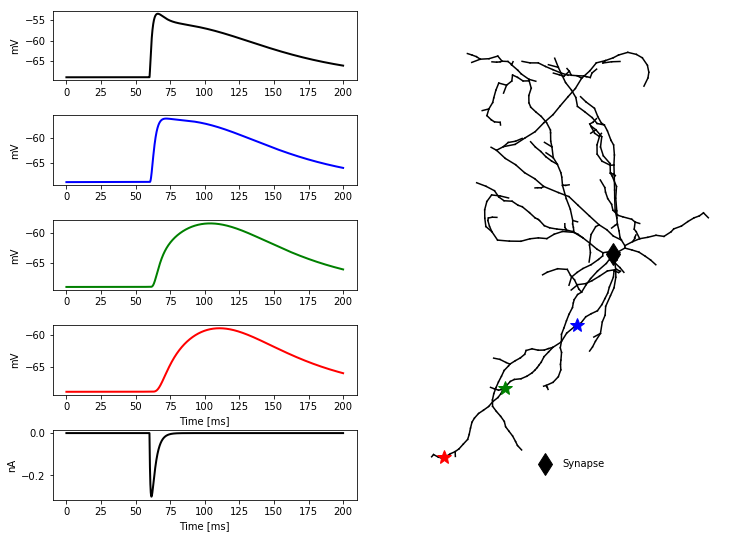

In [15]:
cell_name = "halnes"
weight = 0.005
somapos = 0
distdendpos = 128
closedendpos = 65
fardendpos = 110
mypos = somapos

cell_folder = join(cell_name)

end_T = 200
dt = 2**-5
start_T = -200
cell = return_interneuron(end_T, dt, start_T)

synapse = insert_synapses(cell, weight=weight, pos = mypos)
cell.simulate(rec_imem=False, rec_vmem=True, synpos = mypos)

plot_signal(cell, synapse, mypos)
plt.savefig("cell_hbp_%s.png" % cell_name)

## 4) Optional: Dendritic Na⁺ and K⁺ channels
Presumingly, your simulations in 1) showed that action potentials (evoked in the soma) only gave rise to small voltage deflections in the tip of the dendrite. Conversely, experiments have shown that the action potential shape and amplitude are fairly well preserved when they propagate from the soma to the distal dendrites in these interneurons (Casale et al., 2011, Journal of Neuroscience, 31(50):18289–18302). This indicates that not only the soma, but also the dendrites contain a nonzero density of Na⁺ and K⁺ channels.

__a)__ Insert Na⁺ and K⁺ channels (with some density/conductance) in the dendrites, and see if you can can make the model account for this observation.

__b)__ How is the response to a synaptic input when you have the dendritic Na⁺ and K⁺ conductances that you found above?